In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, jaccard_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.multioutput import ClassifierChain
from collections import Counter

In [2]:
df = pd.read_csv('./data/marketing_campaign_engineered.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2211 entries, 0 to 2210
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    2211 non-null   int64  
 1   Year_Birth            2211 non-null   int64  
 2   Education             2211 non-null   object 
 3   Marital_Status        2211 non-null   object 
 4   Income                2211 non-null   float64
 5   Kidhome               2211 non-null   int64  
 6   Teenhome              2211 non-null   int64  
 7   Dt_Customer           2211 non-null   object 
 8   Recency               2211 non-null   int64  
 9   MntWines              2211 non-null   int64  
 10  MntFruits             2211 non-null   int64  
 11  MntMeatProducts       2211 non-null   int64  
 12  MntFishProducts       2211 non-null   int64  
 13  MntSweetProducts      2211 non-null   int64  
 14  MntGoldProds          2211 non-null   int64  
 15  NumDealsPurchases    

In [3]:
features = ['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 
            'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
            'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 
            'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
categorical_features = ['Education', 'Marital_Status']
numerical_features = [feature for feature in features if feature not in categorical_features]
labels = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 
          'AcceptedCmp5', 'AcceptedCmp6']

In [4]:
df[df['NumAcceptedCampaigns'] == 0].shape, df[df['NumAcceptedCampaigns'] >= 2].shape

((1606, 39), (236, 39))

The following problem arises with our data. We have more than 72% of the data that hasn't accepted any of the campaigns and only 236 that have accepted two or more. There is a huge class imbalance and furthermore even between the labels we have imbalances. 

Stratifying the splits is a task not supported by the generic `train_test_split` method, thus we need to employ more robust methods like `iterative_train_test_split`. Cross Validation is also problematic since having stratified folds for a multiclass problem is still an unsolved problem and there are no robust algorithms to provide a solution (_Sechidis et al._)

Thus we will try first performing a stratified split but skipping the Cross Validation and trying to fix the hyperparameters "by hand". Next we will also forego stratification in order to try CrossValidation.

## Stratification No CV

Another thing to consider is that depending on the test size, not all classes will be contained on the test/validation set, so we have to consider either having a smaller train size but having all cases included in all splits or not

In [5]:
def prepare_iterative_ts(X, y, features, labels, test_size):
    X_train, y_train, X_test, y_test = iterative_train_test_split(X.values, y.values, test_size = test_size)

    X_train = pd.DataFrame(X_train, columns=features)
    X_test = pd.DataFrame(X_test, columns=features)
    y_train = pd.DataFrame(y_train, columns=labels)
    y_test = pd.DataFrame(y_test, columns=labels)

    return X_train, X_test, y_train, y_test

In [6]:
X_trainval, X_test, y_trainval, y_test = prepare_iterative_ts(df[features], df[labels], features, labels, test_size=0.1)
X_train, X_val, y_train, y_val = prepare_iterative_ts(X_trainval, y_trainval, features, labels, test_size=0.32)

### RidgeClassifier

Ridge Classifier inherently supports multilabel tasks, we will just standardize the data and one hot encode the categorical variables.

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(categories=[['Graduation', 'PhD', 'Master', 'Basic'], 
                                          ['Single', 'Together', 'Married', 'Divorced', 
                                           'Widow', 'Others']]), categorical_features)
    ])

In [8]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)

In [9]:
ridge_clf_1 = RidgeClassifier(fit_intercept=False) # intercept not needed since data already centered
ridge_clf_1.fit(X_train_transformed, y_train)

RidgeClassifier(fit_intercept=False)

In [10]:
predictions = ridge_clf_1.predict(X_val_transformed)
print(classification_report(y_val, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        47
           3       1.00      0.02      0.04        47
           4       0.83      0.21      0.34        47
           5       0.67      0.15      0.24        96

   micro avg       0.74      0.09      0.16       286
   macro avg       0.42      0.06      0.10       286
weighted avg       0.53      0.09      0.14       286
 samples avg       0.03      0.02      0.03       286



In [11]:
y_val[y_val.sum(axis=1) == 0].shape, y_val.shape

((459, 6), (637, 6))

Trying RidgeClassifiers with different alphas

In [12]:
ridge_clf_2 = RidgeClassifier(fit_intercept=False, alpha=0.1) # intercept not needed since data already centered
ridge_clf_2.fit(X_train_transformed, y_train)
print(classification_report(y_val, ridge_clf_2.predict(X_val_transformed), zero_division=0))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        47
           3       1.00      0.02      0.04        47
           4       0.83      0.21      0.34        47
           5       0.67      0.15      0.24        96

   micro avg       0.74      0.09      0.16       286
   macro avg       0.42      0.06      0.10       286
weighted avg       0.53      0.09      0.14       286
 samples avg       0.03      0.02      0.03       286



In [13]:
ridge_clf_3 = RidgeClassifier(fit_intercept=False, alpha=0.01) # intercept not needed since data already centered
ridge_clf_3.fit(X_train_transformed, y_train)
print(classification_report(y_val, ridge_clf_3.predict(X_val_transformed), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        47
           3       1.00      0.02      0.04        47
           4       0.83      0.21      0.34        47
           5       0.67      0.15      0.24        96

   micro avg       0.71      0.09      0.16       286
   macro avg       0.42      0.06      0.10       286
weighted avg       0.53      0.09      0.14       286
 samples avg       0.03      0.02      0.03       286



In [14]:
ridge_clf_4 = RidgeClassifier(fit_intercept=False, alpha=10) # intercept not needed since data already centered
ridge_clf_4.fit(X_train_transformed, y_train)
print(classification_report(y_val, ridge_clf_4.predict(X_val_transformed), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        47
           3       1.00      0.02      0.04        47
           4       0.83      0.21      0.34        47
           5       0.67      0.15      0.24        96

   micro avg       0.71      0.09      0.16       286
   macro avg       0.42      0.06      0.10       286
weighted avg       0.53      0.09      0.14       286
 samples avg       0.03      0.02      0.03       286



In [15]:
ridge_clf_5 = RidgeClassifier(fit_intercept=False, alpha=100) # intercept not needed since data already centered
ridge_clf_5.fit(X_train_transformed, y_train)
print(classification_report(y_val, ridge_clf_5.predict(X_val_transformed), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        47
           3       1.00      0.02      0.04        47
           4       0.69      0.19      0.30        47
           5       0.70      0.17      0.27        96

   micro avg       0.68      0.09      0.16       286
   macro avg       0.40      0.06      0.10       286
weighted avg       0.51      0.09      0.15       286
 samples avg       0.03      0.02      0.03       286



Seems like changing the alphas either has no influence or worsens the performers

### LogisticRegression with ClassifierChains

LogisticRegression inherently does not support any multilabel classification however when used as part of a ClassifierChain it can perform multilabel tasks. Furthermore ClassifierChains allow for exploiting correlations among targets. 

Clearly the order of the chain is important. The first model in the chain has no information about the other labels while the last model in the chain has features indicating the presence of all of the other labels. In general one does not know the optimal ordering of the models in the chain so typically many randomly ordered chains are fit and their predictions are averaged together.

In [16]:
def plot_jaccard_similarities_for_chains(chain_jaccard_scores, ensemble_jaccard_score, y_valid, Y_pred_ensemble, text):
    # Prepare scores for plotting
    model_scores = chain_jaccard_scores + [ensemble_jaccard_score]
    model_names = [f"Chain {i+1}" for i in range(20)] + ["Ensemble"]
    x_pos = np.arange(len(model_names))

    valid_report = classification_report(y_valid, (Y_pred_ensemble >= 0.3).astype(int) , zero_division=0)
    print("Validation Report (Ensemble):\n", valid_report)

    # Plotting
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.grid(True)
    ax.set_title(text)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation="vertical")
    ax.set_ylabel("Jaccard Similarity Score")
    ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
    colors = ["b"] * 20 + ["g"]
    ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
    plt.tight_layout()
    plt.show()

Validation Report (Ensemble):
               precision    recall  f1-score   support

           0       0.42      0.34      0.38        41
           1       0.33      0.25      0.29         8
           2       0.33      0.17      0.23        47
           3       0.53      0.38      0.44        47
           4       0.63      0.57      0.60        47
           5       0.47      0.40      0.43        96

   micro avg       0.48      0.37      0.42       286
   macro avg       0.45      0.35      0.39       286
weighted avg       0.47      0.37      0.42       286
 samples avg       0.08      0.09      0.08       286



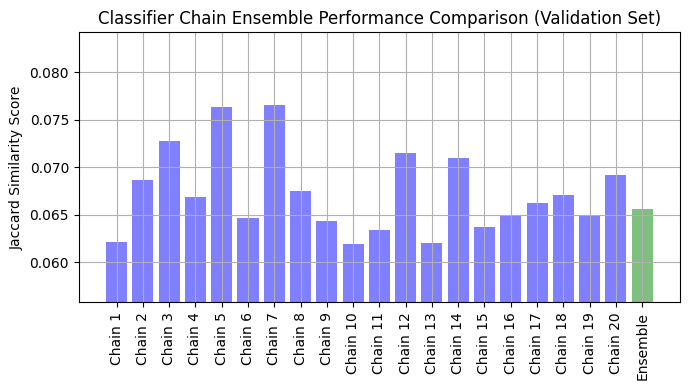

In [17]:
chains = []
Y_pred_chains = []
for i in range(20):
    base_lr = LogisticRegression(solver='sag', max_iter=10000)
    chain = ClassifierChain(base_estimator=base_lr, order="random", random_state=i)
    chain.fit(X_train_transformed, y_train)
    chains.append(chain)
    Y_pred_chain = chain.predict_proba(X_val_transformed)
    Y_pred_chains.append(Y_pred_chain)

# Calculate Jaccard Similarity Score for each chain
chain_jaccard_scores = [jaccard_score(y_val, Y_pred_chain >= 0.3, average="samples", zero_division=0) for Y_pred_chain in Y_pred_chains]
    
# Calculate Jaccard Similarity Score for ensemble
Y_pred_ensemble = np.mean(Y_pred_chains, axis=0)
ensemble_jaccard_score = jaccard_score(y_val, Y_pred_ensemble >= 0.3, average="samples", zero_division=0)

plot_jaccard_similarities_for_chains(chain_jaccard_scores, ensemble_jaccard_score, y_val, Y_pred_ensemble, "Classifier Chain Ensemble Performance Comparison (Validation Set)")

As shown on the sklearn documentation, the ClassifierChain Ensemble should perform better than the other chains, however that is not the case here. We note that the threshold for a label to be positive has been reduced from 0.5 to 0.3 since we have almost three quarters of the data without any predicted label, thus the confidence is also low.

We see that Chain 7 achiever the best results. Let's compute the metrics for this chain

In [18]:
valid_report = classification_report(y_val, (Y_pred_chains[6] >= 0.3).astype(int) , zero_division=0)
print("Validation Report (Chain 7):\n", valid_report)

Validation Report (Chain 7):
               precision    recall  f1-score   support

           0       0.42      0.32      0.36        41
           1       0.25      0.25      0.25         8
           2       0.35      0.19      0.25        47
           3       0.52      0.36      0.42        47
           4       0.58      0.68      0.63        47
           5       0.47      0.47      0.47        96

   micro avg       0.47      0.41      0.44       286
   macro avg       0.43      0.38      0.40       286
weighted avg       0.46      0.41      0.43       286
 samples avg       0.09      0.10      0.09       286



## Testing the final model (7th chain)

In [19]:
X_test_transformed = preprocessor.transform(X_test)
Y_pred_chain_test = chains[6].predict_proba(X_test_transformed)

valid_report = classification_report(y_test, (Y_pred_chain_test >= 0.3).astype(int) , zero_division=0)
print("Test Report (Chain 7):\n", valid_report)

Test Report (Chain 7):
               precision    recall  f1-score   support

           0       0.50      0.43      0.46        14
           1       0.50      0.67      0.57         3
           2       0.38      0.19      0.25        16
           3       0.67      0.38      0.48        16
           4       0.71      0.75      0.73        16
           5       0.50      0.42      0.46        33

   micro avg       0.55      0.44      0.49        98
   macro avg       0.54      0.47      0.49        98
weighted avg       0.54      0.44      0.48        98
 samples avg       0.08      0.08      0.08        98



## Retraining with Validation set and testing

In [20]:
X_trainval_transformed = preprocessor.fit_transform(X_trainval)
X_test_transformed = preprocessor.transform(X_test)

Validation Report (Ensemble):
               precision    recall  f1-score   support

           0       0.55      0.43      0.48        14
           1       1.00      0.67      0.80         3
           2       0.38      0.19      0.25        16
           3       0.64      0.44      0.52        16
           4       0.73      0.69      0.71        16
           5       0.54      0.39      0.46        33

   micro avg       0.59      0.43      0.50        98
   macro avg       0.64      0.47      0.54        98
weighted avg       0.58      0.43      0.49        98
 samples avg       0.07      0.08      0.07        98



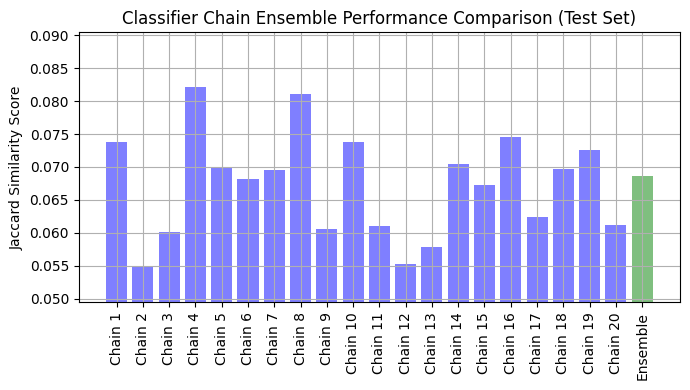

In [21]:
chains = []
Y_pred_chains = []
for i in range(20):
    base_lr = LogisticRegression(solver='sag', max_iter=10000)
    chain = ClassifierChain(base_estimator=base_lr, order="random", random_state=i)
    chain.fit(X_trainval_transformed, y_trainval)
    chains.append(chain)
    Y_pred_chain = chain.predict_proba(X_test_transformed)
    Y_pred_chains.append(Y_pred_chain)

# Calculate Jaccard Similarity Score for each chain
chain_jaccard_scores = [jaccard_score(y_test, Y_pred_chain >= 0.3, average="samples", zero_division=0) for Y_pred_chain in Y_pred_chains]
    
# Calculate Jaccard Similarity Score for ensemble
Y_pred_ensemble = np.mean(Y_pred_chains, axis=0)
ensemble_jaccard_score = jaccard_score(y_test, Y_pred_ensemble >= 0.3, average="samples", zero_division=0)

plot_jaccard_similarities_for_chains(chain_jaccard_scores, ensemble_jaccard_score, y_test, Y_pred_ensemble, "Classifier Chain Ensemble Performance Comparison (Test Set)")

In [22]:
test_report = classification_report(y_test, (Y_pred_chains[3] >= 0.3).astype(int) , zero_division=0)
print("Test Report (Chain 4):\n", valid_report)

Test Report (Chain 4):
               precision    recall  f1-score   support

           0       0.50      0.43      0.46        14
           1       0.50      0.67      0.57         3
           2       0.38      0.19      0.25        16
           3       0.67      0.38      0.48        16
           4       0.71      0.75      0.73        16
           5       0.50      0.42      0.46        33

   micro avg       0.55      0.44      0.49        98
   macro avg       0.54      0.47      0.49        98
weighted avg       0.54      0.44      0.48        98
 samples avg       0.08      0.08      0.08        98



## Trying RethinkNet

In [64]:
import tensorflow as tf

# F1 Score Calculation Function
def f1_score(y_true, y_pred):
    # Calculate the L1 norm which is the count of 1's in binary labels
    y_true_sum = tf.reduce_sum(y_true)
    y_pred_sum = tf.reduce_sum(y_pred)

    # Intersection of y and y_hat
    intersection = tf.reduce_sum(y_true * y_pred)

    # F1 score for each label
    f1 = 2 * intersection / (y_true_sum + y_pred_sum + tf.keras.backend.epsilon())
    return f1

# Weight Computation Function
@tf.function
def compute_weights(y_true, y_pred, t):
    num_labels = y_pred.shape[-1]
    batch_size = tf.shape(y_pred)[0]

    if t > 1:
        weights = tf.TensorArray(dtype=tf.float32, size=batch_size)

        for i in tf.range(batch_size):
            sample_weights = tf.TensorArray(dtype=tf.float32, size=num_labels)
            
            for j in tf.range(num_labels):
                # Prepare y_pred with the j-th label set to 0 and 1
                y_pred_0 = tf.concat([y_pred[i, :j], [0], y_pred[i, j+1:]], axis=0)
                y_pred_1 = tf.concat([y_pred[i, :j], [1], y_pred[i, j+1:]], axis=0)

                # Add new axis for batch compatibility
                y_pred_0 = y_pred_0[tf.newaxis, :]
                y_pred_1 = y_pred_1[tf.newaxis, :]

                # Compute F1 scores for each case
                f1_0 = f1_score(y_true[i:i+1, :], y_pred_0)
                f1_1 = f1_score(y_true[i:i+1, :], y_pred_1)

                # Compute the weight for this label
                weight = tf.abs(f1_0 - f1_1)
                sample_weights = sample_weights.write(j, weight)

            # Stack the weights for all labels for this sample
            weights = weights.write(i, sample_weights.stack())

        # Stack the weights for all samples
        weights = weights.stack()
    else:
        weights = tf.ones((batch_size, num_labels))

    return weights

# Custom Loss Function
class WeightedBinaryCrossEntropy(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
        self.weights = None

    def set_weights(self, weights):
        self.weights = weights

    def call(self, y_true, y_pred):
        if self.weights is None:
            raise ValueError("Weights not set for WeightedBinaryCrossEntropy")
        
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        weighted_bce = self.weights * bce
        return tf.reduce_mean(tf.reduce_sum(weighted_bce, axis=-1))

# RNN Layer
@tf.keras.utils.register_keras_serializable()
class RethinkNetRNN(tf.keras.layers.Layer):
    def __init__(self, units, B):
        super(RethinkNetRNN, self).__init__()
        self.units = units
        self.B = B
        self.U = tf.keras.layers.Dense(units, activation=None)  # Linear transformation
        self.W = tf.keras.layers.Dense(units, activation=None)  # Linear transformation

    def call(self, x):
        o_prev = tf.zeros_like(x)
        for i in range(self.B):
            if i == 0:
                o = tf.nn.sigmoid(self.U(x))
            else:
                o = tf.nn.sigmoid(self.U(x) + self.W(o_prev))
            o_prev = o
        return o
    
    def get_config(self):
        config = super(RethinkNetRNN, self).get_config()
        config.update({
            'units': self.units,
            'B': self.B
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# RethinkNet Model
@tf.keras.utils.register_keras_serializable()
class RethinkNet(tf.keras.Model):
    def __init__(self, feature_dim, label_dim, B):
        super(RethinkNet, self).__init__()
        self.rnn = RethinkNetRNN(feature_dim, B)
        self.dense = tf.keras.layers.Dense(label_dim, activation='sigmoid')
        self.feature_dim = feature_dim
        self.B = B
        self.label_dim = label_dim

    def call(self, inputs):
        rnn_output = self.rnn(inputs)
        return self.dense(rnn_output)
    
    def call(self, inputs):
        rnn_output = self.rnn(inputs)
        return self.dense(rnn_output)

    def get_config(self):
        config = super(RethinkNet, self).get_config()
        config.update({
            'feature_dim': self.feature_dim,
            'label_dim': self.label_dim,
            'B': self.B
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

def train_model(model, X_train, Y_train, patience, epochs=10, batch_size=32, learning_rate=0.01):

    loss_fn = WeightedBinaryCrossEntropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Convert to TensorFlow tensors
    X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
    Y_train_tf = tf.convert_to_tensor(Y_train, dtype=tf.float32)

    best_loss = float('inf')
    epochs_without_improvement = 0
    loss_history = []

    for epoch in range(epochs):
        indices = tf.range(start=0, limit=tf.shape(X_train_tf)[0], dtype=tf.int32)
        shuffled_indices = tf.random.shuffle(indices)

        X_train_shuffled = tf.gather(X_train_tf, shuffled_indices)
        Y_train_shuffled = tf.gather(Y_train_tf, shuffled_indices)

        for i in range(0, len(X_train_tf), batch_size):
            x_batch_train = X_train_shuffled[i:i+batch_size]
            y_batch_train = Y_train_shuffled[i:i+batch_size]

            with tf.GradientTape() as tape:
                logits = model(x_batch_train, training=True)
                weights = compute_weights(y_batch_train, logits, epoch + 1)
                loss_fn.set_weights(weights)
                loss_value = loss_fn(y_batch_train, logits)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        loss_history.append(loss_value.numpy())
        # Check for loss improvement
        if loss_value < best_loss:
            best_loss = loss_value
            epochs_without_improvement = 0
            # Save the model
            model.save('nn_model.keras')
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_value.numpy()} - saving model")
        elif patience:
            epochs_without_improvement += 1
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_value.numpy()}")
            print(f"Model not improved. Reducing patience to {patience-epochs_without_improvement}")
            if epochs_without_improvement >= patience:
                print("Stopping early due to no improvement in loss.")
                break
        else:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_value.numpy()}")

    return loss_history

       #print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_value.numpy()}")


In [109]:
feature_dim = X_train_transformed.shape[1]  # Adjust as per your feature vector size
label_dim = y_train.shape[1]    # Adjust as per your label vector size
B = 6
lr = 0.001   

model = RethinkNet(feature_dim, label_dim, B)

# Compile the model
model.compile(optimizer='adam')

# Training loop
epochs = 20  # Set the number of epochs
batch_size = 32  # Set the batch size

loss_history = train_model(model, X_train_transformed, y_train.values, epochs=epochs, batch_size=32, patience=False, learning_rate=lr)

Epoch 1/20, Loss: 2.7238476276397705 - saving model
Epoch 2/20, Loss: 0.06983565539121628 - saving model
Epoch 3/20, Loss: 0.20214048027992249
Epoch 4/20, Loss: 0.3328936696052551
Epoch 5/20, Loss: 0.07793571799993515
Epoch 6/20, Loss: 0.16689476370811462
Epoch 7/20, Loss: 0.15831336379051208
Epoch 8/20, Loss: 0.06663598120212555 - saving model
Epoch 9/20, Loss: 0.13883033394813538
Epoch 10/20, Loss: 0.09514356404542923
Epoch 11/20, Loss: 0.0 - saving model
Epoch 12/20, Loss: 0.19114238023757935
Epoch 13/20, Loss: 0.11864861845970154
Epoch 14/20, Loss: 0.04877306893467903
Epoch 15/20, Loss: 0.0534009113907814
Epoch 16/20, Loss: 0.0
Epoch 17/20, Loss: 0.0616304986178875
Epoch 18/20, Loss: 0.3535468280315399
Epoch 19/20, Loss: 0.0
Epoch 20/20, Loss: 0.2790513336658478


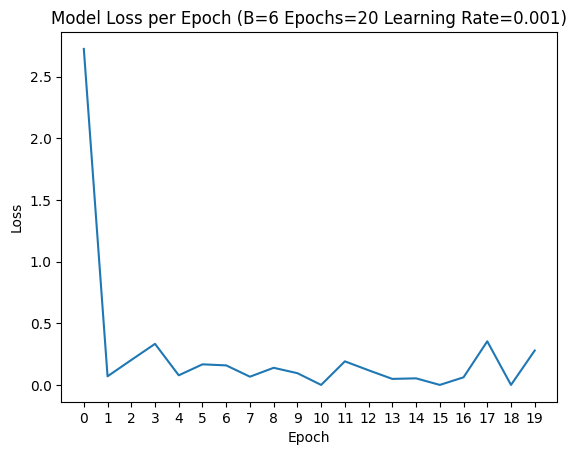

In [110]:
plt.plot(loss_history)
plt.title(f'Model Loss per Epoch (B={B} Epochs={epochs} Learning Rate={lr})')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(loss_history)))
plt.show()

We first try with the latest model. We have to adjust the threshold manually depending on the confidence of the model

In [111]:
predictions = model.predict(X_val_transformed)
predictions

20/20 [==============================] - 1s 2ms/step


array([[0.66891575, 0.35641608, 0.61180645, 0.6790068 , 0.69933206,
        0.71020234],
       [0.69876474, 0.3895672 , 0.59871423, 0.64800125, 0.68991053,
        0.76322764],
       [0.5060894 , 0.24168558, 0.64824617, 0.58500767, 0.5160566 ,
        0.8020272 ],
       ...,
       [0.42135087, 0.24908559, 0.66803086, 0.520375  , 0.47710556,
        0.7606552 ],
       [0.4034807 , 0.27662992, 0.7094969 , 0.5070657 , 0.4536666 ,
        0.74882615],
       [0.5579215 , 0.28435072, 0.7004098 , 0.65867037, 0.45430088,
        0.680155  ]], dtype=float32)

In [115]:
rethink_report = classification_report(y_val, (predictions >= 0.7).astype(int) , zero_division=0)
print(f"Validation Report (RNN B={B}, Epochs={epochs}, LR={lr}):\n", rethink_report)

Validation Report (RNN B=6, Epochs=20, LR=0.001):
               precision    recall  f1-score   support

           0       0.27      0.41      0.33        41
           1       0.00      0.00      0.00         8
           2       0.11      0.30      0.16        47
           3       0.26      0.26      0.26        47
           4       0.26      0.47      0.34        47
           5       0.18      0.96      0.30        96

   micro avg       0.19      0.55      0.28       286
   macro avg       0.18      0.40      0.23       286
weighted avg       0.20      0.55      0.27       286
 samples avg       0.15      0.16      0.14       286



In [87]:
loaded_model = tf.keras.models.load_model('nn_model.keras', custom_objects={'RethinkNetRNN': RethinkNetRNN})
loaded_preds = loaded_model.predict(X_val_transformed)
loaded_preds

20/20 [==============================] - 0s 2ms/step


array([[0.7181757 , 0.4066474 , 0.5412255 , 0.6921861 , 0.73537356,
        0.7947483 ],
       [0.7482622 , 0.40764448, 0.50322366, 0.69049925, 0.77722585,
        0.7932675 ],
       [0.44675273, 0.07940933, 0.6102197 , 0.7194833 , 0.17248814,
        0.81487024],
       ...,
       [0.29992393, 0.03753401, 0.7082117 , 0.4688483 , 0.08225983,
        0.8350779 ],
       [0.20674002, 0.03989379, 0.7402084 , 0.27968308, 0.06524327,
        0.79668707],
       [0.51298434, 0.18132961, 0.5448334 , 0.7719974 , 0.34769318,
        0.7986154 ]], dtype=float32)

In [92]:
rethink_best_report = classification_report(y_val, (loaded_preds >= 0.7).astype(int) , zero_division=0)
print(f"Validation Report Best Loss (RNN B={B}, Epochs={epochs}, LR={0.01}):\n", rethink_best_report)

Validation Report Best Loss (RNN B=15, Epochs=20, LR=0.01):
               precision    recall  f1-score   support

           0       0.21      0.73      0.32        41
           1       0.00      0.00      0.00         8
           2       0.11      0.47      0.18        47
           3       0.19      0.47      0.27        47
           4       0.29      0.87      0.43        47
           5       0.16      1.00      0.27        96

   micro avg       0.18      0.74      0.28       286
   macro avg       0.16      0.59      0.25       286
weighted avg       0.18      0.74      0.28       286
 samples avg       0.15      0.21      0.16       286

